# Vehicle Classification

### Import all the Dependencies

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

2024-07-03 12:57:04.110693: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-03 12:57:04.110798: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-03 12:57:04.247635: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Set all the Constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=60

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/dataset-1/tomato disease dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 6751 files belonging to 10 classes.


In [4]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[8 3 9 7 6 2 6 2 2 7 5 1 3 9 0 1 6 2 2 7 5 9 3 9 3 3 4 9 6 6 3 6]


As you can see above, each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels 

### Visualize some of the images from our dataset

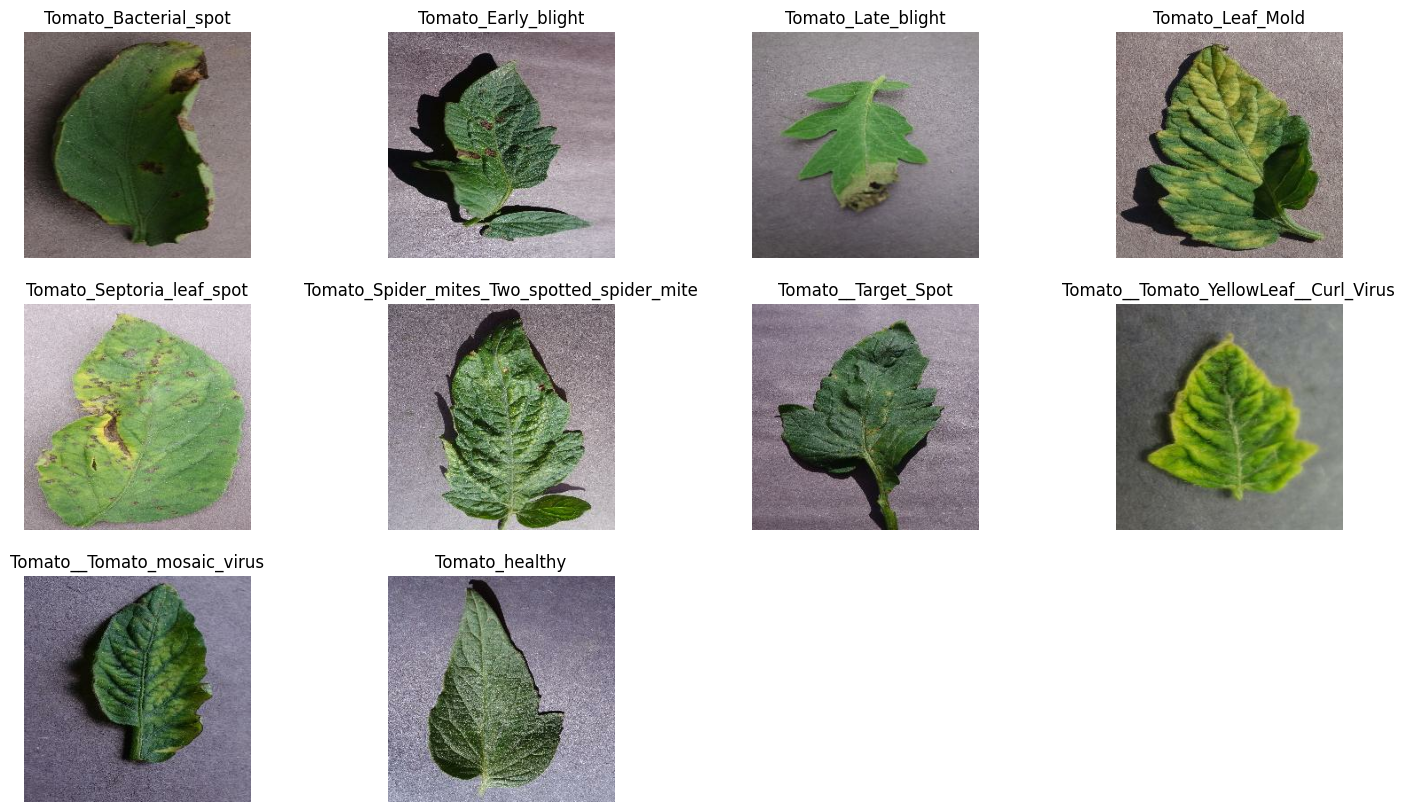

In [6]:
num_classes = len(class_names)
images_per_class = {class_name: None for class_name in class_names}

for image_batch, labels_batch in dataset:
    for img, label in zip(image_batch, labels_batch):
        class_name = class_names[label]
        if images_per_class[class_name] is None:
            images_per_class[class_name] = img
        if all(img is not None for img in images_per_class.values()):
            break
    if all(img is not None for img in images_per_class.values()):
        break

plt.figure(figsize=(18, 10))
for i, (class_name, img) in enumerate(images_per_class.items()):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(class_name)
    plt.axis("off")
plt.show()


### Function to Split Dataset

Dataset should be bifurcated into 3 subsets, namely:
1. Training: Dataset to be used while training
2. Validation: Dataset to be tested against while training
3. Test: Dataset to be tested against after we trained a model

In [7]:
len(dataset)

211

In [8]:
train_size = 0.8
len(dataset)*train_size

168.8

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

157

In [11]:
val_size=0.1
len(dataset)*val_size

21.1

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

151

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

168

In [17]:
len(val_ds)

21

In [18]:
len(test_ds)

22

### Cache, Shuffle, and Prefetch the Dataset

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Building the Model

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. 
Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256).
This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
])

### Data Augmentation
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)



### Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

# Model architecture
model = models.Sequential([
    layers.InputLayer(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1./255),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax'),
])




In [25]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,202 (719.54 KB)

 Trainable params: 184,202 (719.54 KB)

 Non-trainable params: 0 (0.00 B)

### Compiling the Model
We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [26]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size= 64,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 65s 384ms/step - accuracy: 0.3025 - loss: 1.8186 - val_accuracy: 0.2173 - val_loss: 2.3441
Epoch 2/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 57s 340ms/step - accuracy: 0.4300 - loss: 1.4817 - val_accuracy: 0.4271 - val_loss: 1.6763
Epoch 3/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 57s 337ms/step - accuracy: 0.5566 - loss: 1.1828 - val_accuracy: 0.5402 - val_loss: 1.3910
Epoch 4/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 57s 339ms/step - accuracy: 0.6520 - loss: 0.9543 - val_accuracy: 0.4792 - val_loss: 1.9355
Epoch 5/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 57s 337ms/step - accuracy: 0.6891 - loss: 0.8792 - val_accuracy: 0.5193 - val_loss: 1.7961
Epoch 6/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 56s 331ms/step - accuracy: 0.7339 - loss: 0.7352 - val_accuracy: 0.6116 - val_loss: 1.3991
Epoch 7/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 56s 331ms/step - accuracy: 0.7477 - loss: 0.6940 - val_accuracy: 0.6756 - val_loss: 0.9819
Epoch 8/60
168/168 ━━━━━━━━━━━━━━━━━━━━ 56s 331ms/step - accuracy: 0.7664 - loss: 0

In [29]:
scores = model.evaluate(test_ds)

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9666 - loss: 0.1056


**You can see above that we get 100.00% accuracy for our test dataset. This is considered to be a pretty good accuracy**

In [30]:
y_predict=model.predict(test_ds)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [31]:
y_predict

array([[7.9990215e-08, 3.5151319e-07, 4.3751174e-06, ..., 8.8121720e-05,
        7.8459062e-12, 3.0817793e-09],
       [3.8234362e-20, 1.2846893e-11, 5.6659442e-16, ..., 5.2425363e-14,
        9.9999988e-01, 9.6310731e-13],
       [2.2684403e-06, 7.4689257e-01, 3.6509123e-02, ..., 5.2249760e-07,
        1.4672337e-04, 9.7349118e-03],
       ...,
       [1.7135450e-10, 1.0642302e-06, 9.9999893e-01, ..., 6.3811738e-12,
        2.8556845e-15, 1.5575102e-09],
       [3.3453570e-10, 8.5661077e-06, 8.3946745e-04, ..., 5.3048738e-05,
        4.1214837e-05, 2.3364113e-10],
       [1.3982230e-08, 3.9814884e-04, 5.1011233e-07, ..., 4.6083742e-15,
        1.1215215e-15, 1.3469694e-21]], dtype=float32)

In [32]:
y_pred_labels = np.argmax(y_predict, axis=1)

In [33]:
y_pred_labels

array([5, 8, 1, 9, 2, 2, 2, 5, 9, 6, 1, 4, 3, 4, 0, 5, 6, 0, 6, 4, 5, 0,
       4, 0, 3, 2, 1, 1, 7, 8, 2, 3, 2, 2, 9, 9, 1, 5, 0, 2, 0, 3, 1, 1,
       7, 2, 3, 3, 4, 7, 9, 4, 8, 3, 2, 0, 9, 1, 6, 7, 0, 9, 8, 5, 4, 7,
       2, 1, 9, 7, 0, 3, 9, 8, 2, 6, 4, 5, 3, 0, 5, 5, 7, 6, 3, 4, 3, 2,
       5, 5, 0, 3, 2, 1, 2, 1, 1, 9, 9, 0, 1, 1, 4, 9, 5, 0, 9, 6, 0, 1,
       6, 4, 7, 0, 6, 1, 0, 6, 5, 4, 0, 5, 6, 1, 0, 6, 0, 2, 0, 7, 3, 0,
       6, 5, 9, 9, 7, 3, 5, 3, 2, 5, 6, 2, 0, 5, 4, 9, 6, 2, 3, 1, 5, 5,
       5, 9, 0, 6, 4, 2, 9, 8, 9, 2, 5, 8, 6, 7, 9, 9, 4, 9, 5, 3, 6, 2,
       1, 8, 1, 0, 8, 6, 0, 7, 3, 2, 2, 3, 5, 8, 4, 0, 2, 8, 9, 8, 1, 7,
       9, 1, 2, 2, 0, 6, 2, 6, 0, 6, 4, 0, 8, 6, 2, 0, 5, 4, 4, 3, 6, 2,
       5, 0, 9, 9, 9, 2, 6, 4, 9, 2, 2, 8, 0, 6, 5, 1, 2, 9, 2, 0, 7, 9,
       2, 9, 9, 4, 0, 6, 4, 2, 3, 2, 5, 1, 5, 5, 8, 2, 0, 9, 3, 9, 3, 9,
       5, 7, 0, 4, 9, 6, 1, 4, 8, 9, 7, 3, 2, 3, 8, 7, 2, 3, 7, 4, 7, 9,
       0, 9, 9, 7, 3, 0, 4, 6, 3, 1, 0, 3, 6, 1, 8,

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [34]:
history

You can read documentation on history object here: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History

In [35]:
history.params

{'verbose': 1, 'epochs': 60, 'steps': 168}

In [36]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

**loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch**

In [37]:
type(history.history['loss'])

list

In [38]:
len(history.history['loss'])

60

In [39]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.7404632568359375,
 1.4288080930709839,
 1.1219700574874878,
 0.9575293660163879,
 0.8331090807914734]

In [40]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

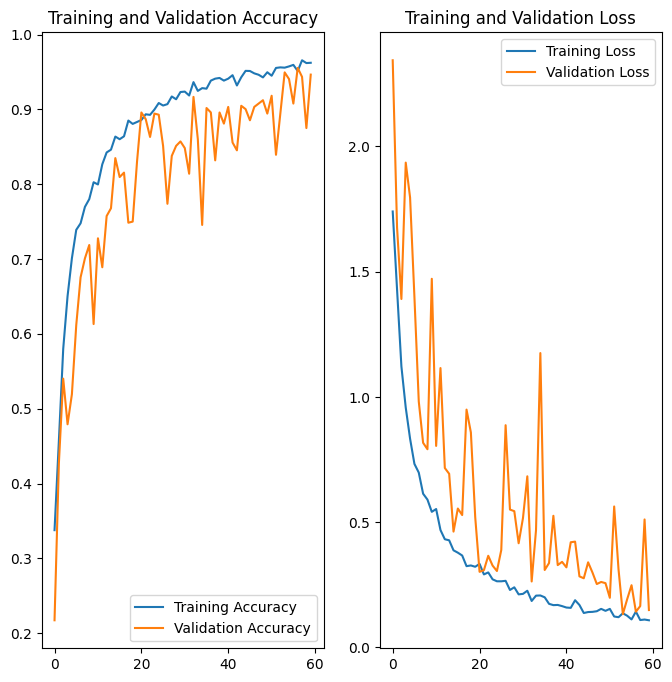

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Run prediction on a sample image

first image to predict
actual label: Tomato_healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
predicted label: Tomato_healthy


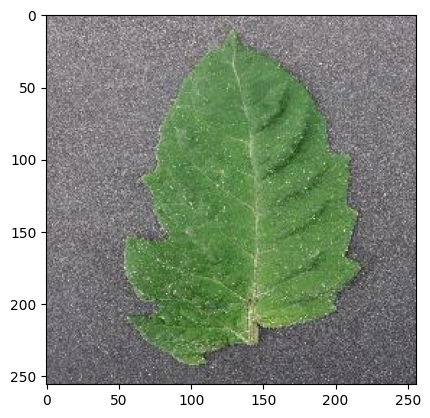

In [42]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

### Write a function for inference

In [43]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

**Now run inference on few sample images**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


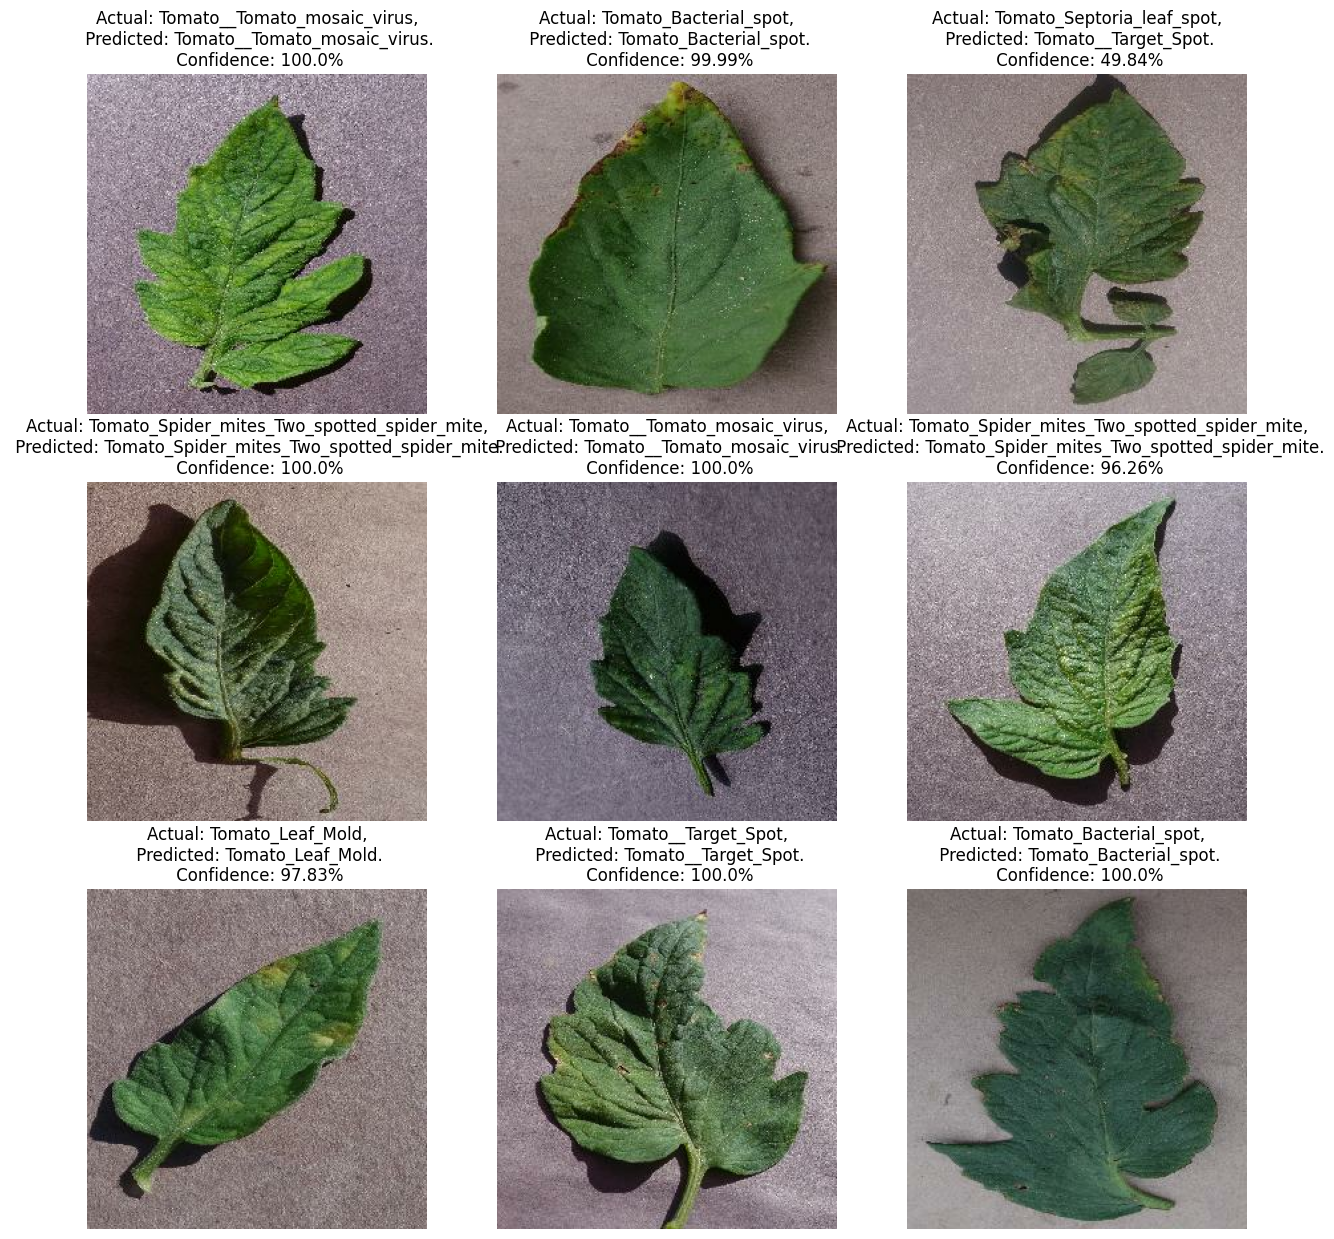

In [51]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

### Saving the Model
We append the model to the list of models as a new version

In [45]:
# import os
# model_version=max([int(i) for i in os.listdir("Model") + [0]])+1
# model.save(f"Model/{model_version}")

In [50]:
model.save("Tomato_60.h5")
